In [143]:
import numpy as np
from scipy import optimize
import os
import pandas as pd
import ipdb
import warnings
import torch
import torch.nn as nn
from s_annealing_cost_solution import compute_proper_ratio_pl
warnings.filterwarnings("ignore")

def compute_distance_matrix(X, center_roads):
    lat2 = torch.deg2rad(X[:,0]).reshape((-1,1))
    lat1 = torch.deg2rad(center_roads[:,0]).reshape((1,-1))
    lon2 = torch.deg2rad(X[:,1]).reshape((-1,1))
    lon1 = torch.deg2rad(center_roads[:,1]).reshape((1,-1))
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = torch.sin(dlat/2)**2 + torch.cos(lat1)*torch.cos(lat2)*torch.sin(dlon/2)**2
    c = 2*torch.arcsin(torch.sqrt(a))
    r = 6371
    distance_matrix_km = c*r
    return distance_matrix_km

def compute_output_costs(distance_matrix_km, flows, maximal_distance):
    outputs_costs=(
        distance_matrix_km.min(axis=0).values * (distance_matrix_km.min(axis=0).values>maximal_distance) 
        + 0*distance_matrix_km.mean(axis=0)/2
        
    )
    return outputs_costs.mean()



In [160]:
distance_matrix.shape

torch.Size([50, 3061])

In [140]:
from sklearn.cluster import KMeans

In [156]:
number_clusters = 50
maximal_distance = 100
# maximal_distance = maximal_distance
steps = 20

In [157]:
raw_data = pd.read_csv(os.path.join("data","tmja-2019.csv"), sep=";")
for colonne in raw_data.columns:
    try:
        raw_data[colonne] = raw_data[colonne].apply(lambda element:element.replace(',',"."))
    except:
        # print(raw_data[colonne].dtype)
        pass
for colonne in raw_data.columns:
    try:
        raw_data[colonne] = raw_data[colonne].astype(float)
    except:
        pass

df = raw_data[["route",'xD',"yD","xF", "yF","TMJA","ratio_PL"]]
df.loc[:, ['xD',"yD","xF", "yF"]]/=1e5
values =["x","y"]
for value in values:
    df.loc[:,f'center_{value}'] = (df.loc[:, f"{value}D"]+df.loc[:,f"{value}F"])/2
df['proper_ratio_PL'] = df["ratio_PL"].apply(compute_proper_ratio_pl)
df.dropna(inplace=True)
df["daily_flow_trucks"] = (df["proper_ratio_PL"]/100) *df['TMJA']
df['scaled_flow_trucks'] = df['daily_flow_trucks']/1000
Y = np.random.randn(number_clusters,2)
Y[:,0]+=5
Y[:,0]+=1
Y[:,1]+=64

cluster = KMeans(n_clusters=number_clusters,init='k-means++')
cluster.fit(df[['center_x','center_y']])
Y = cluster.cluster_centers_

Y_0 = torch.tensor(Y, requires_grad=True)
x = Y_0
center_roads = torch.Tensor(df[['center_x','center_y']].values)
flows = torch.Tensor(df['daily_flow_trucks'].values)
optimizer = torch.optim.SGD([x], lr=0.1)
steps = 200
for i in range(steps):
    # 
    optimizer.zero_grad()
    
    distance_matrix = compute_distance_matrix(x, center_roads)
    # distance_matrix_between_points = compute_distance_matrix(x, x)
    total_loss = compute_output_costs(distance_matrix, flows, maximal_distance)
    total_loss.backward()
    optimizer.step()
    if i%50==0:
        print(total_loss.detach())
    # x = torch.clamp(x, min=2, max=73)

tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)


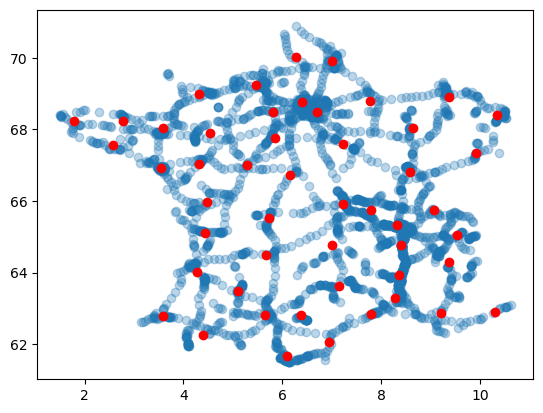

In [158]:
import matplotlib.pyplot as plt
x_plot = x.detach().cpu().numpy()

plt.scatter(df['center_x'], df['center_y'],alpha=0.3)
plt.scatter(x_plot[:,0], x_plot[:,1], color='red')

In [97]:
distance_matrix.min(axis=0).values * (distance_matrix.min(axis=0).values>maximal_distance) + distance_matrix.mean(axis=0)

tensor([22539.6777, 22534.1790, 22533.9771,  ..., 22334.2347, 22607.3887,
        22608.5685], dtype=torch.float64, grad_fn=<AddBackward0>)